In [1]:
import platform
import subprocess

import cartopy.crs as ccrs
import dask
import matplotlib.pyplot as plt
import metpy
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import scipy as sp
import xarray

# Variable Glossary
In the following cell you can set the values of the variables relevant to the postprocess. The details of each variable are included below. Note that any variable included in the model should be given the same value in the postprocess. For example, if the model used zw = 42 and kmax = 11, you should use zw = 42 and kmax = 11 below.


## Standard Variables
In most cases it is only necessary to set values for the standard variables.

**zw** is the zonal wave number. For standard use, zw should be set to the value of either 42, 63, or 124. Setting the value for zw also sets default values jmax and imax.
<br>Set zw = 42, to set jmax = 64 and imax = 128.
<br>Set zw = 63, to set jmax = 96 and imax = 192.
<br>Set zw = 124, to set jmax = 188 and imax = 376.
<br>Each of these variables (jmax and imax) that is given a value in the advanced variables section will instead use that value.

**kmax** is the number of vertical levels. The value of kmax should be 11 or 26 for standard use.

**Expname** is the name you gave to your experiment. When the data was saved to your computer, it was saved in a folder with this name. This variable should be set to the same experiment name you used when running the model.

**DataSetname** is the name of the data set. This will be used to name files that are created by this program.

**Dataname** is the name of the data. This is what will be used to label the data in the charts generated by this program.

**dayst** is the number of days over which the data spans. This number will be used to label the data as it's output to files and will also be used to run this program and display the data.


## Advanced Variables
While most cases only require setting the standard variables, some cases might require setting some or all advanced variables as well. The following variables should only be changed from their default value if a specific behavior is desired. An advanced variable set to the value of None will use the default case.

**jmax** is the number of Gaussian latitudes. jmax = imax/2

**imax** is the number of longitude grid points. imax >= 3 * zw + 1. imax must be an even number.

**custom_path** is the full path of the folder in which you saved your data. If custom_path is set, expname is ignored. If you used a custom_path when running the model, you must use the same custom_path here to access the same data.

**custom_kmax** is used to safeguard against using unexpected values for the kmax. If custom_kmax is set, it will be used instead of kmax. By default the program only supports kmax with a value of either 11 or 26. Other values are implementable, but the user must modify subs1_utils.py routine bscst. If unclear email bkirtman@miami.edu for clarification.

In [2]:
# Set postprocess parameters.

# Standard Variables
zw = 63
kmax = 26
Expname = 'GammaT63L26_Warm'
DataSetname = 'vvel'
Dataname = 'v'
dayst = 4800

# Advanced Variables
imax = 192
jmax = 96
custom_path = None
custom_kmax = None

In [ ]:
# Set Dependent Variables

# Set value of kmax if custom_kmax is used.
if not(custom_kmax is None):
    kmax = custom_kmax
    print("Using custom value for kmax:", kmax)
# Otherwise check value for kmax.
elif kmax!=11 and kmax!=26:
    raise Exception("Unexpected value for kmax. Use custom_kmax and note that other values are implementable, but the user must modify subs1_utils.py routine bscst. If unclear email bkirtman@miami.edu for clarification.")

# Check value for zw.
# Afterwards, set jmax and imax values based on the value given to zw.
# If a value is already given for one of the listed variables, use that instead
match zw:
    case 42:
        jmax = 64 if (jmax is None) else jmax
        imax = 128 if (imax is None) else imax
    case 63:
        jmax = 96 if (jmax is None) else jmax
        imax = 192 if (imax is None) else imax
    case 124:
        jmax = 188 if (jmax is None) else jmax
        imax = 376 if (imax is None) else imax
    case _:
        if (jmax is None) or (imax is None):
            raise Exception("Unexpected value for zw. Other values are implementable, but the user must specify values for jmax and imax in the advanced variables section.")

print("zw =", zw,
      "\nkmax =", kmax,
      "\njmax =", jmax,
      "\nimax =", imax,
      "\ndayst =", dayst)

In [ ]:
# Set datapath.

# If custom_path was set, use that as the datapath.
# Otherwise create an appropriate datapath for the user's operating system.
user_platform = platform.system() if (custom_path is None) else "Custom Path"
print("Setting output datapath for", user_platform)
datapath = ''
match user_platform:
    case 'Custom Path':
        datapath = custom_path
    case 'Windows':
        foo = str(subprocess.check_output(['whoami']))
        end = len(foo) - 5
        uname = foo[2:end].split("\\\\")[1]
        datapath = "C:\\Users\\" + uname + "\\Documents\\AGCM_Experiments\\" + Expname + "\\"
    case 'Darwin':
        foo = str(subprocess.check_output(['whoami']))
        end = len(foo) - 3
        uname = foo[2:end]
        datapath = '/Users/' + uname + '/Documents/AGCM_Experiments/' + Expname + '/'
    case _:
        raise Exception("Use case for this system/OS is not implemented. Consider using custom_path in the advanced variables.")

# Set stamp for file names
stamp = 'days_1-' + str(dayst)

print("datapath =", datapath,
      "\nstamp =", stamp)

In [3]:
fps = datapath+'lnps_1*.nc' # always need surface pressure
dps = xarray.open_mfdataset(fps,decode_times=True,parallel = True)
#
#
fdata = datapath+DataSetname+'_1*.nc'
ddata = xarray.open_mfdataset(fdata,decode_times=True,parallel = True)

In [4]:
fps

'/raid6C/kirtman/AGCM/GammaT63L26_Warm/lnps_1*.nc'

In [5]:
dps

<xarray.Dataset>
Dimensions:  (time: 4800, lat: 96, lon: 192)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1963-02-21
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    lnps     (time, lat, lon) float64 dask.array<chunksize=(30, 96, 192), meta=np.ndarray>

In [6]:
ddata

<xarray.Dataset>
Dimensions:  (time: 4800, lev: 26, lat: 96, lon: 192)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1963-02-21
  * lev      (lev) float64 0.001123 0.005056 0.01163 ... 0.9294 0.9705 0.9925
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    v        (time, lev, lat, lon) float64 dask.array<chunksize=(30, 26, 96, 192), meta=np.ndarray>

In [7]:
#
# Create Data Array for Control Pressure level Data geopotenial, temp, u & v
# 
#
lats = ddata['lat'].values
lons = ddata['lon'].values
plev = [1000.0,900.0,800.0,700.0,600.0,500.0,400.0,300.0,200.0,100.0,20.0]
plev_r = np.zeros(11)
for k in range(11):
    plev_r[k] = (plev[k])*100.0 # mb to Pa
#
#
tmp = (dayst,11,jmax,imax) #### "11" here corresponds to standard pressure levels not to model levels
dout = np.zeros(tmp)
pressure = np.zeros((kmax,jmax,imax))
siglevs = ddata['lev']
for k in range (dayst):
    vv = ddata[Dataname][k,:,:,:]
    ps = dps.lnps[k,:,:]
    surfp = (np.exp(ps))*1000.0*100.0 # in Pa
    for kk in range(kmax):
        pressure[kk,:,:] = surfp[:,:]*siglevs[kk]
    vv = vv.compute()
    ps = ps.compute()
    dout[k] = metpy.interpolate.log_interpolate_1d(plev_r,pressure,vv, axis=0)
#
times = ddata['time']
dData = xarray.Dataset({Dataname: (['time','lev','lat','lon'],dout)},
                        coords={'time': times,'lev':plev, 'lat': lats, 'lon': lons})

/tmp/ipykernel_4120934/3970498570.py:26: UserWarning: Interpolation point out of data bounds encountered
  dout[k] = metpy.interpolate.log_interpolate_1d(plev_r,pressure,vv, axis=0)
/tmp/ipykernel_4120934/3970498570.py:26: UserWarning: Interpolation point out of data bounds encountered
  dout[k] = metpy.interpolate.log_interpolate_1d(plev_r,pressure,vv, axis=0)
/tmp/ipykernel_4120934/3970498570.py:26: UserWarning: Interpolation point out of data bounds encountered
  dout[k] = metpy.interpolate.log_interpolate_1d(plev_r,pressure,vv, axis=0)
/tmp/ipykernel_4120934/3970498570.py:26: UserWarning: Interpolation point out of data bounds encountered
  dout[k] = metpy.interpolate.log_interpolate_1d(plev_r,pressure,vv, axis=0)
/tmp/ipykernel_4120934/3970498570.py:26: UserWarning: Interpolation point out of data bounds encountered
  dout[k] = metpy.interpolate.log_interpolate_1d(plev_r,pressure,vv, axis=0)
/tmp/ipykernel_4120934/3970498570.py:26: UserWarning: Interpolation point out of data boun

In [8]:
dData

<xarray.Dataset>
Dimensions:  (time: 4800, lev: 11, lat: 96, lon: 192)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1963-02-21
  * lev      (lev) float64 1e+03 900.0 800.0 700.0 ... 300.0 200.0 100.0 20.0
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Data variables:
    v        (time, lev, lat, lon) float64 -0.1767 -0.1464 ... 0.3382 0.3098

In [9]:
dData.to_netcdf(datapath+DataSetname+'_Pressure_'+stamp+'.nc')

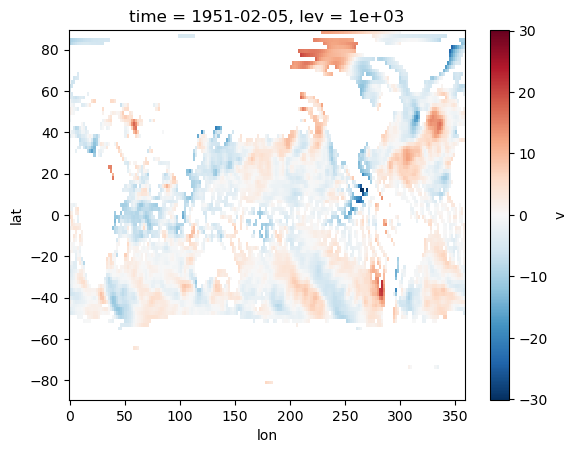

In [10]:
dData[Dataname][400,0,:,:].plot()

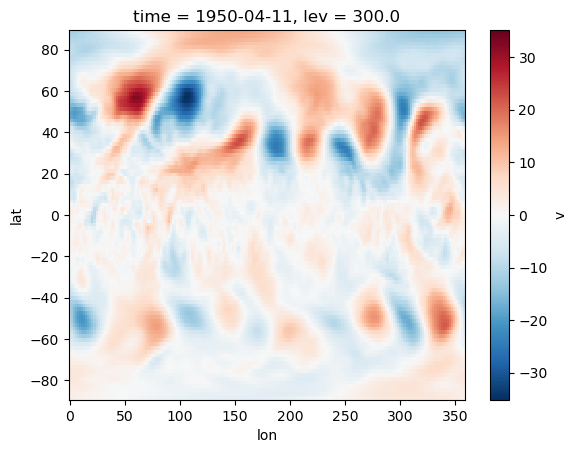

In [11]:
dData[Dataname][100,7,:,:].plot()

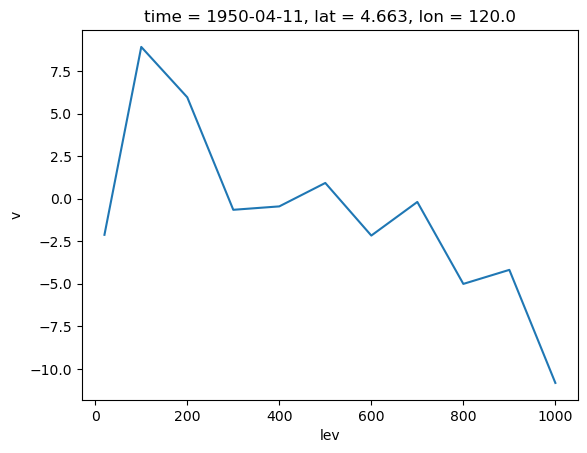

In [12]:
dData[Dataname][100,:,45,64].plot()